### Forecast de demanda: Facturapp

#### ✅ TimeGPT

##### Datos

In [142]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

In [143]:
import pandas as pd

# Rutas a los archivos CSV
clientes_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecasting_for_planning/csv/clientes.csv'
productos_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecasting_for_planning/csv/productos.csv'
ventas_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecasting_for_planning/csv/ventas.csv'

# Leer los archivos CSV
clientes_df = pd.read_csv(clientes_path)
productos_df = pd.read_csv(productos_path)
ventas_df = pd.read_csv(ventas_path)

In [144]:
# Asegúrate de que 'monto_ventas_producto' sea numérico
ventas_df['monto_ventas_producto'] = pd.to_numeric(ventas_df['cantidad_ventas_producto'], errors='coerce')

# Agrupa por tipo de moneda y suma los montos de ventas
suma_por_moneda = ventas_df.groupby('moneda_venta')['cantidad_ventas_producto'].sum()

# Calcular el total de todas las ventas
total_ventas = suma_por_moneda.sum()

# Crear un nuevo DataFrame con los montos y los porcentajes
resultado = pd.DataFrame({
    'Monto Total': suma_por_moneda,
    'Porcentaje del Total': (suma_por_moneda / total_ventas) * 100
})

# Formatear los montos y porcentajes para mejor legibilidad
resultado['Monto Total'] = resultado['Monto Total'].apply(lambda x: f"{x:,.2f}")
resultado['Porcentaje del Total'] = resultado['Porcentaje del Total'].apply(lambda x: f"{x:.2f}%")

# Verificar el resultado
resultado

,Monto Total,Porcentaje del Total
moneda_venta,,
$,"1,460,236.00",99.99%
U$S,140.00,0.01%


In [145]:
# Filtrar por tipo de moneda (por ejemplo, solo $)
ventas_filtrado = ventas_df.loc[ventas_df['moneda_venta'] == '$  ']

# Crear la tabla agregada con el DataFrame filtrado
df = ventas_filtrado.groupby('fecha_venta').agg(
    cantidad_ventas_producto=pd.NamedAgg(column='cantidad_ventas_producto', aggfunc='sum')
).reset_index()

# Renombramos variables para que Prophet tome como input
df = df.rename(columns={'fecha_venta': 'ds', 'cantidad_ventas_producto': 'y'})

# Asegurarse de que 'ds' sea un datetime
df['ds'] = pd.to_datetime(df['ds'])

# Revisar los datos resampleados
df.head()


,ds,y
0,2022-04-16,39.000
1,2022-04-17,165.640
2,2022-04-18,2235.130
3,2022-04-19,1167.624
4,2022-04-20,1734.857


Completamos las fechas faltantes con valores nulos

In [146]:
import pandas as pd

# Supongamos que tu DataFrame original es 'df' y ya tiene la columna 'ds' con fechas
# Asegúrate de que la columna 'ds' esté en formato datetime
df['ds'] = pd.to_datetime(df['ds'])

# Crear un rango completo de fechas desde la mínima hasta la máxima fecha en tu DataFrame
full_date_range = pd.date_range(start=df['ds'].min(), end=df['ds'].max())

# Reindexar tu DataFrame usando este rango de fechas
df = df.set_index('ds').reindex(full_date_range).reset_index()

# Renombrar la columna de fechas nuevamente a 'ds'
df = df.rename(columns={'index': 'ds'})

# Llenar los valores faltantes en la columna 'y' con 0
df['y'] = df['y'].fillna(0)

# Verificar el resultado
df.head()


,ds,y
0,2022-04-16,39.000
1,2022-04-17,165.640
2,2022-04-18,2235.130
3,2022-04-19,1167.624
4,2022-04-20,1734.857


##### Para modelar vacaciones y eventos especiales con selección manual

In [147]:
import pandas as pd

# Lista de los nombres de los feriados
holiday_names = ['Año Nuevo', 'Reyes', 'Carnaval', 'Semana Santa', 'Día del Trabajador', 'Natalicio de Artigas', 
                 'Jura de la Constitución', 'Declaratoria de la Independencia', 'Día de la Raza', 'Día de los Difuntos', 'Navidad']

# Fechas base de los feriados (solo un año de ejemplo, luego generaremos para otros años)
holiday_dates = ['01-01', '01-06', '02-12', '03-28', '05-01', '06-19', '07-18', '08-25', '10-12', '11-02', '12-25']

# Crear una lista vacía para almacenar los feriados
all_holidays = []

# Generar los feriados para los años desde 2022 hasta 2026
for year in range(2022, 2027):
    for i, date in enumerate(holiday_dates):
        all_holidays.append({
            'holiday': holiday_names[i],
            'ds': pd.to_datetime(f'{year}-{date}'),
            'lower_window': -3,  # Afecta 3 días antes del feriado
            'upper_window': 3    # Afecta 3 días después del feriado
        })

# Convertir la lista de diccionarios a un DataFrame de pandas
holidays_uruguay = pd.DataFrame(all_holidays)

# Mostrar los primeros datos
holidays_uruguay.head(11)


,holiday,ds,lower_window,upper_window
0,Año Nuevo,2022-01-01,-3,3
1,Reyes,2022-01-06,-3,3
2,Carnaval,2022-02-12,-3,3
3,Semana Santa,2022-03-28,-3,3
4,Día del Trabajador,2022-05-01,-3,3
5,Natalicio de Artigas,2022-06-19,-3,3
6,Jura de la Constitución,2022-07-18,-3,3
7,Declaratoria de la Independencia,2022-08-25,-3,3
8,Día de la Raza,2022-10-12,-3,3
9,Día de los Difuntos,2022-11-02,-3,3


##### Ingeniería de atributos

In [148]:
import pandas as pd
import numpy as np

# Crear características adicionales a partir de la columna de fechas 'ds'
df['ds'] = pd.to_datetime(df['ds'])
# Asegurarse de que la columna de fechas en holidays_uruguay esté en formato datetime
holidays_uruguay['ds'] = pd.to_datetime(holidays_uruguay['ds'])

# Crear características basadas en la fecha
df['day_of_week'] = df['ds'].dt.dayofweek
df['day_of_month'] = df['ds'].dt.day
df['month'] = df['ds'].dt.month
df['year'] = df['ds'].dt.year
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)


# Crear características basadas en la fecha
df['day_of_week'] = df['ds'].dt.dayofweek
df['day_of_month'] = df['ds'].dt.day
df['month'] = df['ds'].dt.month
df['year'] = df['ds'].dt.year
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['quarter'] = df['ds'].dt.quarter
df['week_of_year'] = df['ds'].dt.isocalendar().week  # Semana del año (ISO)
df['day_of_year'] = df['ds'].dt.dayofyear  # Día del año


# Crear una nueva columna 'is_holiday' en df_train y df_test
df = pd.merge(df, holidays_uruguay[['ds', 'holiday']], on='ds', how='left')
df['is_holiday'] = df['holiday'].apply(lambda x: 1 if pd.notnull(x) else 0)

# Eliminar la columna 'holiday_name' ya que solo queremos 'is_holiday' como input
df = df.drop(columns=['holiday'])

# Rolling window
df['rolling_mean_2'] = df['y'].rolling(window=2, min_periods=1).mean()
df['rolling_mean_7'] = df['y'].rolling(window=7, min_periods=1).mean()
#df['rolling_mean_14'] = df['y'].rolling(window=14, min_periods=1).mean()
#df['rolling_mean_21'] = df['y'].rolling(window=21, min_periods=1).mean()
df['rolling_mean_30'] = df['y'].rolling(window=30, min_periods=1).mean()

# Eliminar filas con valores NaN generados por el rolling
df = df.dropna()

df.head()

,ds,y,day_of_week,day_of_month,month,year,is_weekend,quarter,week_of_year,day_of_year,is_holiday,rolling_mean_2,rolling_mean_7,rolling_mean_30
0,2022-04-16,39.000,5,16,4,2022,1,2,15,106,0,39.0000,39.000000,39.000000
1,2022-04-17,165.640,6,17,4,2022,1,2,15,107,0,102.3200,102.320000,102.320000
2,2022-04-18,2235.130,0,18,4,2022,0,2,16,108,0,1200.3850,813.256667,813.256667
3,2022-04-19,1167.624,1,19,4,2022,0,2,16,109,0,1701.3770,901.848500,901.848500
4,2022-04-20,1734.857,2,20,4,2022,0,2,16,110,0,1451.2405,1068.450200,1068.450200


##### Train y test set

In [149]:
TEST_DATE = '2024-01-15'

df_train = df[df['ds'] < TEST_DATE]
df_test = df[df['ds'] >= TEST_DATE]


print("Datos de training: ", len(df_train), " - ", round((len(df_train)/len(df)),2)*100, "%")
print("Datos de testing: ", len(df_test), " - ", round((len(df_test)/len(df)),2)*100, "%")

Datos de training:  639  -  82.0 %
Datos de testing:  136  -  18.0 %


##### TimeGPT-1

In [150]:
import pandas as pd
from nixtla import NixtlaClient

In [151]:
# Get your API Key at dashboard.nixtla.io

# 1. Instantiate the NixtlaClient
nixtla_client = NixtlaClient(api_key = 'nixtla-tok-kBaAOIBEprApGiouqPaDWOXVoedcnK24VbizErEORaRlVNppXdsR5HHnfB9F7ZTWjEXalsVNx27YKPSk')

In [152]:
nixtla_client.validate_api_key()

True

In [158]:
# Seleccionar variables exógenas
X_df = df_test[['ds', 'day_of_week', 'day_of_month', 'month', 'year', 'is_weekend', 'quarter', 'week_of_year', 'day_of_year', 'is_holiday', 'rolling_mean_2', 'rolling_mean_7', 'rolling_mean_30']]
#X_df = df_test[['ds', 'day_of_week', 'day_of_month', 'is_weekend', 'week_of_year', 'day_of_year', 'is_holiday', 'rolling_mean_2', 'rolling_mean_7', 'rolling_mean_30']]

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using the following exogenous variables: day_of_week, day_of_month, month, year, is_weekend, quarter, week_of_year, day_of_year, is_holiday, rolling_mean_2, rolling_mean_7, rolling_mean_30
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


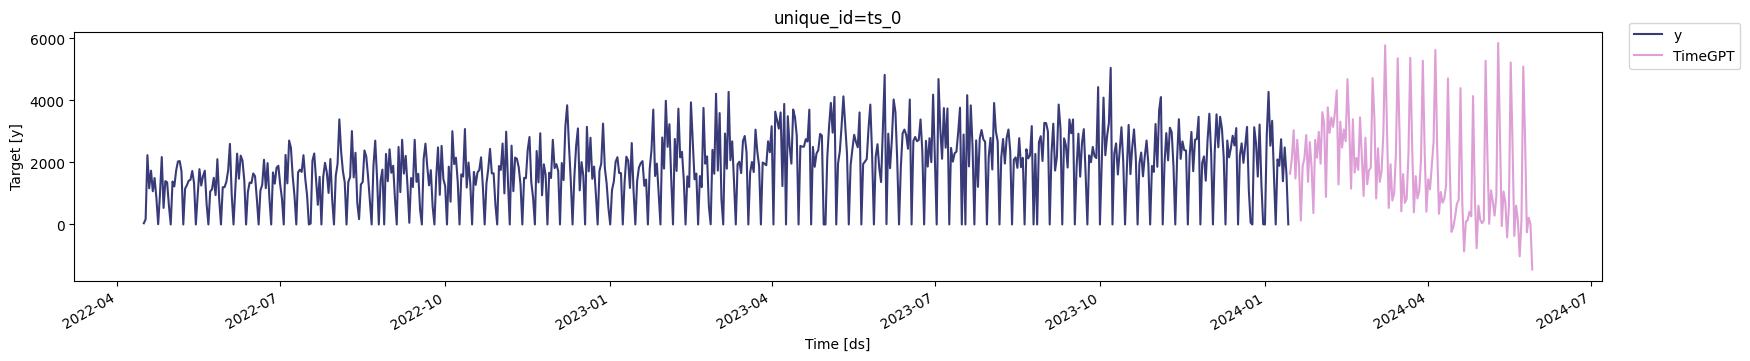

In [162]:
timegpt_fcst_df = nixtla_client.forecast(df=df_train, X_df=X_df, h=136, time_col='ds', target_col='y', freq='D')
nixtla_client.plot(df_train, timegpt_fcst_df, time_col='ds', target_col='y')

In [160]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Asegúrate de que los valores reales y predicciones estén alineados
actuals = df_test['y'].values  # Valores reales
predictions = timegpt_fcst_df['TimeGPT'].values  # Predicciones del modelo

# Calcular MAE
mae = mean_absolute_error(actuals, predictions)

# Calcular MSE
mse = mean_squared_error(actuals, predictions)

# Calcular RMSE
rmse = np.sqrt(mse)

# Filtrar valores donde actuals no sea igual a 0
non_zero_actuals = actuals != 0
filtered_actuals = actuals[non_zero_actuals]
filtered_predictions = predictions[non_zero_actuals]

# Calcular MAPE sólo para valores donde actuals no sea 0
mape = np.mean(np.abs((filtered_actuals - filtered_predictions) / filtered_actuals)) * 100

# Mostrar resultados
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 1090.70
MSE: 1881733.22
RMSE: 1371.76
MAPE: 84.78%


In [182]:
df_test

,ds,y,day_of_week,day_of_month,month,year,is_weekend,quarter,week_of_year,day_of_year,is_holiday,rolling_mean_2,rolling_mean_7,rolling_mean_30
639,2024-01-15,2858.739,0,15,1,2024,0,1,3,15,0,1431.0885,1855.161143,1841.676633
640,2024-01-16,3009.568,1,16,1,2024,0,1,3,16,0,2934.1535,2014.846143,1941.995567
641,2024-01-17,2148.314,2,17,1,2024,0,1,3,17,0,2578.9410,1928.979143,1940.043567
642,2024-01-18,2786.417,3,18,1,2024,0,1,3,18,0,2467.3655,2127.962714,1945.679633
643,2024-01-19,2496.509,4,19,1,2024,0,1,3,19,0,2641.4630,2129.571714,1962.650033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,2024-05-25,2632.372,5,25,5,2024,1,2,21,146,0,2635.5630,1748.586429,1985.407233
771,2024-05-26,0.000,6,26,5,2024,1,2,21,147,0,1316.1860,1748.586429,1920.517067
772,2024-05-27,918.313,0,27,5,2024,0,2,22,148,0,459.1565,1669.101143,1871.757067
773,2024-05-28,1692.885,1,28,5,2024,0,2,22,149,0,1305.5990,1720.266571,1928.186567


In [181]:
timegpt_fcst_df

,TimeGPT
ds,
2024-01-15,1636.106258
2024-01-16,2134.897430
2024-01-17,3039.638321
2024-01-18,1483.602609
2024-01-19,2729.252931
...,...
2024-05-25,2776.159239
2024-05-26,-249.528395
2024-05-27,216.725798


In [206]:
# Realizar el merge entre df_test y timegpt_fcst_df basado en la columna 'ds'
merged_df = pd.merge(
    df_test,                  # DataFrame base
    timegpt_fcst_df,          # DataFrame a unir
    on='ds',                  # Columna clave para el merge
    how='inner'               # Solo fechas comunes ('inner join')
)

# Visualizar el resultado
merged_df.head()


,ds,y,day_of_week,day_of_month,month,year,is_weekend,quarter,week_of_year,day_of_year,is_holiday,rolling_mean_2,rolling_mean_7,rolling_mean_30,TimeGPT
0,2024-01-15,2858.739,0,15,1,2024,0,1,3,15,0,1431.0885,1855.161143,1841.676633,1636.106258
1,2024-01-16,3009.568,1,16,1,2024,0,1,3,16,0,2934.1535,2014.846143,1941.995567,2134.897430
2,2024-01-17,2148.314,2,17,1,2024,0,1,3,17,0,2578.9410,1928.979143,1940.043567,3039.638321
3,2024-01-18,2786.417,3,18,1,2024,0,1,3,18,0,2467.3655,2127.962714,1945.679633,1483.602609
4,2024-01-19,2496.509,4,19,1,2024,0,1,3,19,0,2641.4630,2129.571714,1962.650033,2729.252931


In [207]:
df_results_best = pd.DataFrame({
    'Fecha': merged_df['ds'],  # Índice de tiempo de test
    'Actual': merged_df['y'],        # Valores reales
    'Predicted': merged_df['TimeGPT'] # Predicciones de XGBoost
}).set_index('Fecha')

In [208]:
df_results_best

,Actual,Predicted
Fecha,,
2024-01-15,2858.739,1636.106258
2024-01-16,3009.568,2134.897430
2024-01-17,2148.314,3039.638321
2024-01-18,2786.417,1483.602609
2024-01-19,2496.509,2729.252931
...,...,...
2024-05-25,2632.372,2776.159239
2024-05-26,0.000,-249.528395
2024-05-27,918.313,216.725798


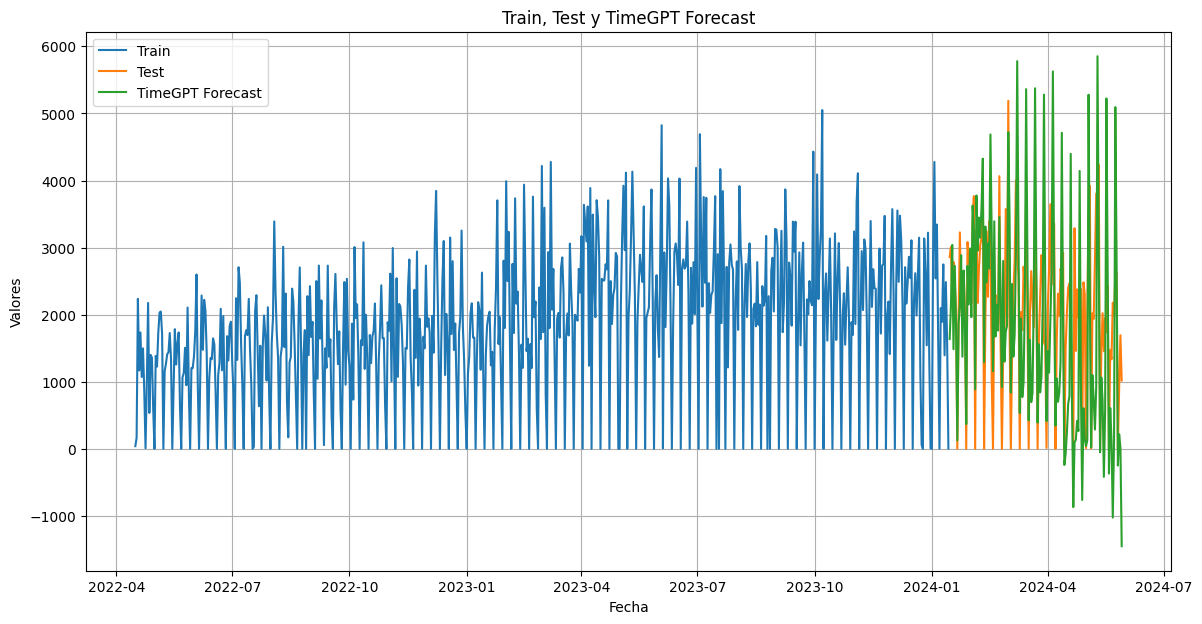

In [209]:
import matplotlib.pyplot as plt

# Gráfico de series: Train, Test y Forecast
plt.figure(figsize=(14, 7))

# Serie de entrenamiento
plt.plot(df_train['ds'], df_train['y'], label='Train', color='tab:blue')

# Serie de prueba
plt.plot(df_test['ds'], df_test['y'], label='Test', color='tab:orange')

# Predicciones
plt.plot(df_test['ds'], df_results_best['Predicted'], label='TimeGPT Forecast', color='tab:green')

# Configuración del gráfico
plt.title('Train, Test y TimeGPT Forecast')
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.legend()
plt.grid()
plt.show()


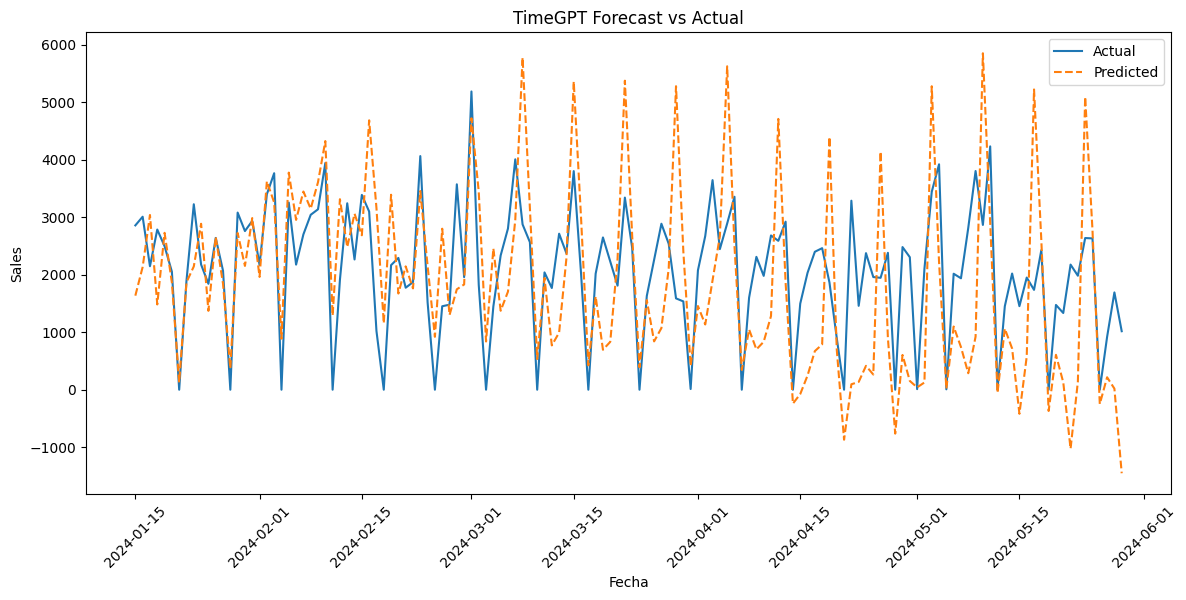

In [210]:
# Gráfico de valores reales vs predicciones
plt.figure(figsize=(14, 6))

# Valores reales
plt.plot(df_test['ds'], df_results_best['Actual'], label='Actual', color='tab:blue')

# Predicciones
plt.plot(df_test['ds'], df_results_best['Predicted'], label='Predicted', linestyle='--', color='tab:orange')

# Configuración del gráfico
plt.title('TimeGPT Forecast vs Actual')
plt.xlabel('Fecha')
plt.ylabel('Sales')
plt.xticks(rotation=45)  # Rotar etiquetas de fecha
plt.legend()
plt.show()